# B1: Federated Averaging.

### Name: Vinayak Rai


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Logistic/paper/logistic.pdf)

2. Read, complete, and run my code.

3. **Implement mini-batch SGD** and evaluate the performance.

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
    * Missing **the output after execution** will not be graded.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo.  (If you submit the file to Google Drive or Dropbox, you must make the file "open-access". The delay caused by "deny of access" may result in late penalty.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/HM2/HM2.html


## Grading criteria:

1. When computing the ```gradient``` and ```objective function value``` using a batch of samples, use **matrix-vector multiplication** rather than a FOR LOOP of **vector-vector multiplications**.

2. Plot ```objective function value``` against ```epochs```. In the plot, compare GD, SGD, and MB-SGD (with $b=8$ and $b=64$). The plot must look reasonable.

# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [1]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [2]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [3]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[-0.07187787  0.06006189 -0.09102497 -0.02397864  0.06039257 -0.0245659
   0.15831709  0.07897736]]
test std = 
[[0.91471416 0.97494103 1.13058742 1.01560775 1.10314909 1.05593675
  1.34113806 1.04781731]]


## 1.4. Add a dimension of all ones

In [4]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


# 2. Logistic regression model

The objective function is $Q (w; X, y) = \frac{1}{n} \sum_{i=1}^n \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

In [5]:
# Calculate the objective function value
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     objective function value (scalar)
def objective(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(-yxw) # n-by-1 matrix
    vec2 = numpy.log(1 + vec1) # n-by-1 matrix
    loss = numpy.mean(vec2) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    return loss + reg
    

In [6]:
# initialize w
d = x_train.shape[1]
w = numpy.zeros((d, 1))

# evaluate the objective function value at w
lam = 1E-6
objval0 = objective(w, x_train, y_train, lam)
print('Initial objective function value = ' + str(objval0))

Initial objective function value = 0.6931471805599453


# 3. Numerical optimization

## 3.1. Gradient descent


The gradient at $w$ is $g = - \frac{1}{n} \sum_{i=1}^n \frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$

In [7]:
# Calculate the gradient
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     g: g: d-by-1 matrix, full gradient
def gradient(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(yxw) # n-by-1 matrix
    vec2 = numpy.divide(yx, 1+vec1) # n-by-d matrix
    vec3 = -numpy.mean(vec2, axis=0).reshape(d, 1) # d-by-1 matrix
    g = vec3 + lam * w
    return g

In [8]:
# Gradient descent for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_iter: integer, the maximal iterations
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: d-by-1 matrix, the solution
#     objvals: a record of each iteration's objective value
def grad_descent(x, y, lam, stepsize, max_iter=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_iter) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_iter):
        objval = objective(w, x, y, lam)
        objvals[t] = objval
        print('Objective value at t=' + str(t) + ' is ' + str(objval))
        g = gradient(w, x, y, lam)
        w -= stepsize * g
    
    return w, objvals

Run gradient descent.

In [9]:
lam = 1E-6
stepsize = 1.0
w, objvals_gd1 = grad_descent(x_train, y_train, lam, stepsize)

Objective value at t=0 is 0.6931471805599453
Objective value at t=1 is 0.5964055161954884
Objective value at t=2 is 0.5559403830038817
Objective value at t=3 is 0.5340560479834882
Objective value at t=4 is 0.5204153114045377
Objective value at t=5 is 0.5112094807629206
Objective value at t=6 is 0.5046826158970392
Objective value at t=7 is 0.4998974924128015
Objective value at t=8 is 0.49630241892214155
Objective value at t=9 is 0.4935499471095543
Objective value at t=10 is 0.49141039794175606
Objective value at t=11 is 0.48972633792808834
Objective value at t=12 is 0.48838675578324564
Objective value at t=13 is 0.4873115572494209
Objective value at t=14 is 0.4864418368933643
Objective value at t=15 is 0.4857335583114122
Objective value at t=16 is 0.4851533305728653
Objective value at t=17 is 0.48467551783953594
Objective value at t=18 is 0.4842802206660648
Objective value at t=19 is 0.4839518407483266
Objective value at t=20 is 0.4836780441964264
Objective value at t=21 is 0.4834490019

## 3.2. Stochastic gradient descent (SGD)

Define $Q_i (w) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

The stochastic gradient at $w$ is $g_i = \frac{\partial Q_i }{ \partial w} = -\frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [10]:
# Calculate the objective Q_i and the gradient of Q_i
# Inputs:
#     w: d-by-1 matrix
#     xi: 1-by-d matrix
#     yi: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def stochastic_objective_gradient(w, xi, yi, lam):
    d = xi.shape[0]
    yx = yi * xi # 1-by-d matrix
    yxw = float(numpy.dot(yx, w)) # scalar
    
    # calculate objective function Q_i
    loss = numpy.log(1 + numpy.exp(-yxw)) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    obj = loss + reg
    
    # calculate stochastic gradient
    g_loss = -yx.T / (1 + numpy.exp(yxw)) # d-by-1 matrix
    g = g_loss + lam * w # d-by-1 matrix
    
    return obj, g

In [11]:
# SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def sgd(x, y, lam, stepsize, max_epoch=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_epoch) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_epoch):
        # randomly shuffle the samples
        rand_indices = numpy.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]
        
        objval = 0 # accumulate the objective values
        for i in range(n):
            xi = x_rand[i, :] # 1-by-d matrix
            yi = float(y_rand[i, :]) # scalar
            obj, g = stochastic_objective_gradient(w, xi, yi, lam)
            objval += obj
            w -= stepsize * g
        
        stepsize *= 0.9 # decrease step size
        objval /= n
        objvals[t] = objval
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))
    
    return w, objvals

Run SGD.

In [12]:
lam = 1E-6
stepsize = 0.1
w, objvals_sgd1 = sgd(x_train, y_train, lam, stepsize)

Objective value at epoch t=0 is 0.552207876641306
Objective value at epoch t=1 is 0.5270982246099403
Objective value at epoch t=2 is 0.5208723623331262
Objective value at epoch t=3 is 0.5212041878076763
Objective value at epoch t=4 is 0.513292838458776
Objective value at epoch t=5 is 0.5101621488857637
Objective value at epoch t=6 is 0.5126937147111005
Objective value at epoch t=7 is 0.5040896450535614
Objective value at epoch t=8 is 0.5068122828751764
Objective value at epoch t=9 is 0.5088581963907949
Objective value at epoch t=10 is 0.5056937792528515
Objective value at epoch t=11 is 0.5030604498048017
Objective value at epoch t=12 is 0.4977123565144076
Objective value at epoch t=13 is 0.4994299508142313
Objective value at epoch t=14 is 0.49629504753107545
Objective value at epoch t=15 is 0.49434307833780455
Objective value at epoch t=16 is 0.4961412506090531
Objective value at epoch t=17 is 0.4912495598633437
Objective value at epoch t=18 is 0.49361863128786476
Objective value at ep

# 4. Compare GD with SGD

Plot objective function values against epochs.

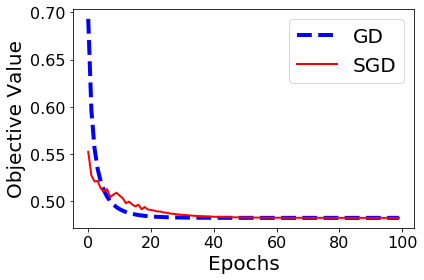

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd1))
epochs_sgd = range(len(objvals_sgd1))

line0, = plt.plot(epochs_gd, objvals_gd1, '--b', LineWidth=4)
line1, = plt.plot(epochs_sgd, objvals_sgd1, '-r', LineWidth=2)
plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1], ['GD', 'SGD'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)

# 5. Prediction

In [14]:
# Predict class label
# Inputs:
#     w: d-by-1 matrix
#     X: m-by-d matrix
# Return:
#     f: m-by-1 matrix, the predictions
def predict(w, X):
    xw = numpy.dot(X, w)
    f = numpy.sign(xw)
    return f

In [15]:
# evaluate training error
f_train = predict(w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

Training classification error is 0.221875


In [16]:
# evaluate test error
f_test = predict(w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Test classification error is 0.203125


In [17]:
class Worker :
    def __init__ (self, x, y):
        self.x = x # n-by-d 
        self.y = y # n by 1
        n = x.shape[0] # no. of samples
        d = x.shape[1] # no. of features
        w = numpy.zeros((d,1))
        
    def set_param(w):
        w = w
        
    def loss():
        yx = numpy.multiply(y, x) # n-by-d matrix
        yxw = numpy.dot(yx, w) # n-by-1 matrix
        vec1 = numpy.exp(-yxw) # n-by-1 matrix
        vec2 = numpy.log(1 + vec1) # n-by-1 matrix
        return numpy.sum(vec2)
    
    def gradient():
        yx = numpy.multiply(y, x) # n-by-d matrix
        yxw = numpy.dot(yx, self.w) # n-by-1 matrix
        vec1 = numpy.exp(yxw) # n-by-1 matrix
        vec2 = numpy.divide(yx, 1+vec1) # n-by-d matrix
        g = -numpy.sum(vec2, axis=0).reshape(self.d, 1) # d-by-1 matrix
       #g = vec3 + lam * w
        return g 
    
    def st_gradient():
        yx = numpy.multiply(y, x) # n-by-d matrix
        yxw = numpy.dot(yx, self.w) # n-by-1 matrix
        vec1 = numpy.exp(yxw)
        sg = -yx.T / (1 + vec1)
        return sg

In [18]:
class Server:
    def __init__(self, m, n, d):
        self.m = m # no. of worker nodes
        self.n = n # no. of training samples
        self.d = d # no. of feautres
        w = numpy.zeros((d,1))
        g = numpy.zeros((d,1))
        v = numpy.zeros((d,1))
        loss = 0 # loss function value
        obj = 0 # objective function value
        
    def broadcast(w):
        return w
    
    # sum loss func and gradients evaluated by workers
    #args
    # grads : a list of d-by-1 vectors
    # loss  : a list of scalars
    
    def aggregate(grads, losses):
        g = numpy.zeros((d, 1))
        loss = 0
        for k in range(m):
            g += grads[k]
            loss += losses[k]
            
    # compute the gradient (from the loss and regularization)
    def gradient(lam):
        g = g / n + lam * w
        
    # compute the objective function(sum of loss and regularization)
    def objective (lam):
        reg = lam / 2 * numpy.sum(w * w)
        obj = loss / n + reg
        return obj
    
    def st_gradient(lam):
        sg = sg  + lam * w
    
    # update the model parameters using Accelerated GD
    # args
    # alpha : learning rate( step size)
    # beta : momentum parameter
    def agd (alpha, beta):
        v *= beta
        v += g
        sw -= alpha * v
        
        

In [19]:
import math

# create a server and m worker nodes:

def create_server_workers (m, x, y):
    n, d = x.shape
    n = math.floor(n / m)
    print(m,n,d)
    server = Server(m, n, d)
    workers = []
    
    for i in range(m):
        indices = list(range(i * n, (i+1)*n))
        worker = Worker(x[indices, :], y[indices,:])
        workers.append(worker)
        
    return server, workers
        

In [20]:
m = 4
server, workers = create_server_workers(m, x_train, y_train)

4 160 9


In [ ]:
lam = 1E-6 #regularization parameter
alpha = 1E-1 #learning rate
beta = 0.9
max_epoch = 100

for t in range(max_epoch):
    # step 1: broadcast
    w = server.broadcast()
#     w = numpy.zeros((d,1))
    print(w)
    for i in range(m):
#         workers[i].set_param(server.broadcast())
        workers[i].set_param(w)
        
        
    # step 2: workers local computations
    grads =[]
    losses =[]
    for i in range(m):
        g = workers[i].gradient()
        grads.append(g)
        l = workers[i].loss()
        losses.append(l)
        
    # step 3: aggregate the workers outputs
    server.aggregate(grads, losses)
    
    # step 4: server update the model paramters
    server.gradient(lam)
    obj = server.objective(lam)
    print('Objective function value for t ='+str(t) + ' is ' + str(obj))
    server.agd(alpha, beta)

# 7. Plot and compare GD, SGD

You are required to compare the following algorithms:

- Gradient descent (GD)

- SGD

 - GD with q=1, GD with q=8, SGD with q=1, SGD with q=8

Follow the code in Section 4 to plot ```objective function value``` against ```epochs```. There should be four curves in the plot; each curve corresponds to one algorithm.

Hint: Logistic regression with $\ell_2$-norm regularization is a strongly convex optimization problem. All the algorithms will converge to the same solution. **In the end, the ``objective function value`` of the 4 algorithms will be the same. If not the same, your implementation must be wrong. Do NOT submit wrong code and wrong result!**

In [ ]:
# plot the 4 curves:

import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(15, 10))

epochs_gd = range(len(objvals_gd1))
epochs_sgd = range(len(objvals_sgd1))
epochs_gd = range(len(objvals_gd8))
epochs_sgd = range(len(objvals_sgd8))

line0, = plt.plot(epochs_gd, objvals_gd1, '--b', LineWidth=3)
line1, = plt.plot(epochs_sgd, objvals_sgd1, '-r', LineWidth=4)
line2, = plt.plot(epochs_mbsgd8, objvals_gd8, 'g', LineWidth=2)
line3, = plt.plot(epochs_mbsgd64, objvals_sgd8, '--y', LineWidth=3)
plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1, line2, line3], ['GD1', 'SGD1', 'GD8', 'SGD8'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd_mbsgd8_mbsgd64.pdf', format='pdf', dpi=1200)